# Imports

In [111]:
import glob
import os
import numpy as np
import pandas as pd
import cv2
from get_landmarks import get_landmarks
import matplotlib.pyplot as plt

# Data Extraction

In [41]:
path = "clean_data/TEST_TRAIN/"
poses = [os.path.basename(d) for d in glob.glob("clean_data/TEST_TRAIN/*")]

all_imgs_path = []
for pose in poses:
    curr_path = path + pose + "/"
    all_imgs_path += (glob.glob(f"{curr_path}*"))

In [114]:
data = []
for path in all_imgs_path:
    landmarks = get_landmarks(cv2.imread(path))
    landmarks.append(path)
    data.append(landmarks)

df = pd.DataFrame(data)

I0000 00:00:1715839573.567438       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics 655
I0000 00:00:1715839573.914494       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics 655
I0000 00:00:1715839574.232073       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics 655
I0000 00:00:1715839574.587687       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics 655
I0000 00:00:1715839574.947276       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.29), renderer: Intel(R) Iris(TM) Plus Graphics 655


In [115]:
columns = []
for lmk in [f"lmk{x}" for x in range(33)]:
    for each in ["x", "y", "z", "vis"]:
        columns.append(f"{lmk}_{each}")

df = df.rename(columns=dict(zip(df.columns, columns)))

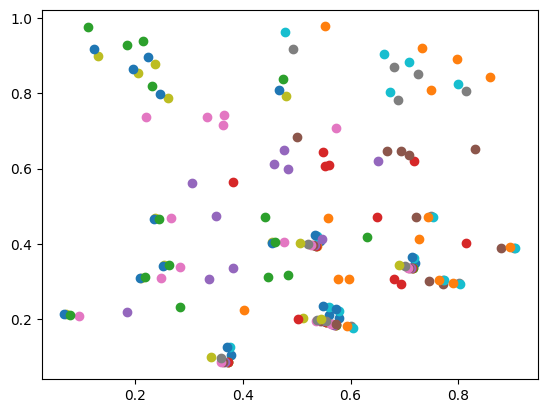

In [118]:
fig, ax = plt.subplots()
for i in range(len(df[xy].columns)// 4):
    x_col = f"lmk{i}_x"
    y_col = f"lmk{i}_y"
    ax.scatter(df[x_col], df[y_col])

plt.show()